# CPP and DynA Clinical Variants aSMD Analysis

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import MDAnalysis as mda
# import lipyphilic as lpp
import matplotlib.pyplot as plt
from scipy.spatial import distance # to calculate pore
from MDAnalysis.analysis import density
import subprocess # To run amber & gromacs commands from jupyter notebook
import MDAnalysis.lib.util as util # To convert from 3 letter to 1 letter aa code

# For occupancy analysis
# import pylipid 
from pylipid.api import LipidInteraction
from matplotlib.patches import Circle # For the radar plot
import matplotlib.colors as mcolors

# To analyse membrane thickness and area per lipid
from lipyphilic.lib.assign_leaflets import AssignLeaflets
from lipyphilic.lib.area_per_lipid import AreaPerLipid
from lipyphilic.lib.memb_thickness import MembThickness

In [2]:
folders = glob.glob('?.*') # Find folders that start with a number and a dot. Then whatever
folders.sort(reverse=False)
print(f'Analysis can be run in folders: {folders}')
# filenames = 
peptides = [i[2:] for i in folders]
peptide_names = ['Control','Arg9', 'MAP', 'TP2', 'DynA WT', 'DynA L5S', 'DynA R6W', 'DynA R9C']
groups = [[1,2,3],[4,5,6,7]]
all_groups = [[0,1,2,3],[4,5,6,7]]
group_names = ['CPPs','DynAs']
membranes = ['','DPPC','DPPCDOPCCHOL','DPPCDOPCDPPSDOPSCHOL']
membrane_names = ['','DPPC','DPPC:DOPC:CHOL','DPPC:DOPC:DPPS:DOPS:CHOL']
peptides_length = [0,9,18,13,17,17,17,17]
# Colors are: ['black','darkgreen','rose','gold','lightgreen','purple','conrflowerblue','orange',lightblue(TP10)]
pept_colors = ['k','#03540A','#8c564b','#bcbd22','#2ED72E','#B50DD2','#1f77b4','#ff7f0e','#17BECF']
data_folder = './Analysis_data/'
plots_folder = './Analysis_plots/'

Analysis can be run in folders: ['0.Control', '0.pdb', '1.Arg9', '2.MAP', '3.TP2', '4.DynAWT', '5.DynAL5S', '6.DynAR6W', '7.DynAR9C', '8.Hysteresis']


In [3]:
pept_num = 0
memb_num = 3
group_num = 0
peptide = peptides[pept_num]
peptide_name = peptide_names[pept_num]
membrane = membranes[memb_num]
membrane_name = membrane_names[memb_num]
pept_color = pept_colors[pept_num]
folder = f'{folders[pept_num]}/{memb_num}.{membrane}/'
pmf_folder = f'{folder}pmf_distances/'
parm_file = f'{folder}step5_input.parm7'
asmd_file = f'{folder}step7.2_only_asmd.nc'
asmd_long_file = f'{folder}step7.2_only_asmd_copy.nc'
traj_file = f'{folder}step7.3_final_relaxation_100ns.nc'
center_file = f'{folder}step7.4_asmd_relax_centered.nc'
print(f'Analysis will be run for: {folders[pept_num]}-{membranes[memb_num]}')

Analysis will be run for: 0.Control-DPPCDOPCDPPSDOPSCHOL


In [37]:
def center_traj(folder):
    # First of all, center trajectory and analyse density

    os.system(f'echo "source /usr/local/AMBER/Ubuntu20.04.6-GPU/Amber20/amber.sh\n\
    cpptraj -p {folder}step5_input.parm7 -y {folder}step7.3_final_relaxation_100ns.nc -i input_cpptraj-1.inp -x {folder}step7.3_centered.nc\n\
    cpptraj -p {folder}step5_input.parm7 -y {folder}step7.3_centered.nc -i input_cpptraj-2.inp\n\
    cpptraj -p {folder}step5_input.parm7 -y {folder}step7.2_only_asmd.nc -y {folder}step7.3_final_relaxation_100ns.nc -i input_cpptraj-1.inp -x {folder}step7.4_asmd_relax_centered.nc">CPPTRAJ')
    os.system('chmod 700 CPPTRAJ')

    subprocess.call(f'/bin/bash -c "source /usr/local/AMBER/Ubuntu20.04.6-GPU/Amber20/amber.sh && ./CPPTRAJ"', shell=True)
    os.system(f'mv density.dat {folder}')

In [38]:
center_traj(folder)


CPPTRAJ: Trajectory Analysis. V5.1.0
    ___  ___  ___  ___
     | \/ | \/ | \/ | 
    _|_/\_|_/\_|_/\_|_

| Date/time: 06/01/24 00:58:14
| Available memory: 1.594 GB

	Reading '0.Control/3.DPPCDOPCDPPSDOPSCHOL/step5_input.parm7' as Amber Topology
	Radius Set: modified Bondi radii (mbondi)
	Reading '0.Control/3.DPPCDOPCDPPSDOPSCHOL/step7.3_final_relaxation_100ns.nc' as Amber NetCDF
	Writing '0.Control/3.DPPCDOPCDPPSDOPSCHOL/step7.3_centered.nc' as Amber NetCDF
INPUT: Reading input from 'input_cpptraj-1.inp'
  [autoimage :PC,PA,OL,PS]
    AUTOIMAGE: To box center based on center of mass, anchor mask is [:PC,PA,OL,PS]
---------- RUN BEGIN -------------------------------------------------

PARAMETER FILES (1 total):
 0: step5_input.parm7, 72404 atoms, 13116 res, box: Tetragonal, 12636 mol, 12154 solvent

INPUT TRAJECTORIES (1 total):
 0: 'step7.3_final_relaxation_100ns.nc' is a NetCDF AMBER trajectory with coordinates, time, box, Parm step5_input.parm7 (Tetragonal box) (reading 1000 of 1

In [39]:
u = mda.Universe(parm_file,traj_file)
a = mda.Universe(parm_file,asmd_file)
# l = mda.Universe(parm_file,asmd_long_file)
c = mda.Universe(parm_file,center_file)

## Distance

In [ ]:
time = [i/10 for i in range(1000)]

In [ ]:
df = pd.DataFrame()
df['Time'] = time
for pept_num in range(7):
    memb_num = 1
    # peptide = peptides[pept_num]
    peptide_name = peptide_names[pept_num]
    membrane = membranes[memb_num]
    membrane_name = membrane_names[memb_num]
    pept_color = pept_colors[pept_num]
    folder = f'{folders[pept_num]}/{memb_num}.{membrane}/'
    parm_file = f'{folder}step5_input.parm7'
    traj_file = f'{folder}step7.3_final_relaxation_100ns.nc'

    u = mda.Universe(parm_file,traj_file)
    z_pos = []
    for _ in u.trajectory:
        z_pos.append(u.select_atoms('protein').center_of_mass()[2])
    df[f'{peptide_names[pept_num]}'] = z_pos

In [ ]:
# df.iloc[:, 1:] = df.iloc[:, 1:].sub(df.iloc[0, 1:], axis=1)
df.iloc[0, 1] *= -1
df

In [ ]:
df.to_csv(f'{data_folder}{memb_num}_peptide_positions_in_relaxation.csv')

In [ ]:
df = pd.DataFrame()
df['Time'] = time
df['Arg9'] = z_pos
df.to_csv(f'{data_folder}peptide_positions.csv')

## PMF

In [13]:
def calculate_pmf(pept_num,memb_num):
    """ This function calculates the pmf of all the replicas in all 8 steps"""
    folder = f'{folders[pept_num]}/{memb_num}.{membranes[memb_num]}/'
    pmf_folder = f'{folder}pmf_distances/' # Define pmf folder
    # Define variable with all the commands that have to be run to calculate pmf
    pmf_write_file = f'''\n cp all_PMF.py {pmf_folder}
    mkdir -p {pmf_folder}step-1 {pmf_folder}step-2 {pmf_folder}step-3 {pmf_folder}step-4 {pmf_folder}step-5 {pmf_folder}step-6 {pmf_folder}step-7 {pmf_folder}step-8
    mv {pmf_folder}distances_sMD_dist_7_1_* {pmf_folder}step-1 | mv {pmf_folder}distances_sMD_dist_7_2_* {pmf_folder}step-2 | mv {pmf_folder}distances_sMD_dist_7_3_* {pmf_folder}step-3 | mv {pmf_folder}distances_sMD_dist_7_4_* {pmf_folder}step-4 | mv {pmf_folder}distances_sMD_dist_7_5_* {pmf_folder}step-5 | mv {pmf_folder}distances_sMD_dist_7_6_* {pmf_folder}step-6 | mv {pmf_folder}distances_sMD_dist_7_7_* {pmf_folder}step-7 | mv {pmf_folder}distances_sMD_dist_7_8_* {pmf_folder}step-8
    cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_1.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_2.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_3.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_4.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_5.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_6.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_7.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_8.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_9.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_10.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_11.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_12.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_13.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_14.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_15.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_16.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_17.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_18.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_19.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_20.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_21.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_22.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_23.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_24.dat | cp {pmf_folder}../distances_sMD_7_1.dat {pmf_folder}step-2/distances_sMD_dist_7_1_25.dat | 
    cp {pmf_folder}step-2/distances_sMD_dist_7_1_* {pmf_folder}step-3 | cp {pmf_folder}step-2/distances_sMD_dist_7_1_* {pmf_folder}step-4 | cp {pmf_folder}step-2/distances_sMD_dist_7_1_* {pmf_folder}step-5 | cp {pmf_folder}step-2/distances_sMD_dist_7_1_* {pmf_folder}step-6 | cp {pmf_folder}step-2/distances_sMD_dist_7_1_* {pmf_folder}step-7 | cp {pmf_folder}step-2/distances_sMD_dist_7_1_* {pmf_folder}step-8
    cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_1.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_2.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_3.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_4.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_5.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_6.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_7.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_8.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_9.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_10.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_11.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_12.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_13.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_14.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_15.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_16.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_17.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_18.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_19.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_20.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_21.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_22.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_23.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_24.dat | cp {pmf_folder}../distances_sMD_7_2.dat {pmf_folder}step-3/distances_sMD_dist_7_2_25.dat | 
    cp {pmf_folder}step-3/distances_sMD_dist_7_2_* {pmf_folder}step-4 | cp {pmf_folder}step-3/distances_sMD_dist_7_2_* {pmf_folder}step-5 | cp {pmf_folder}step-3/distances_sMD_dist_7_2_* {pmf_folder}step-6 | cp {pmf_folder}step-3/distances_sMD_dist_7_2_* {pmf_folder}step-7 | cp {pmf_folder}step-3/distances_sMD_dist_7_2_* {pmf_folder}step-8
    cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_1.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_2.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_3.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_4.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_5.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_6.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_7.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_8.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_9.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_10.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_11.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_12.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_13.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_14.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_15.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_16.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_17.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_18.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_19.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_20.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_21.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_22.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_23.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_24.dat | cp {pmf_folder}../distances_sMD_7_3.dat {pmf_folder}step-4/distances_sMD_dist_7_3_25.dat | 
    cp {pmf_folder}step-4/distances_sMD_dist_7_3_* {pmf_folder}step-5 | cp {pmf_folder}step-4/distances_sMD_dist_7_3_* {pmf_folder}step-6 | cp {pmf_folder}step-4/distances_sMD_dist_7_3_* {pmf_folder}step-7 | cp {pmf_folder}step-4/distances_sMD_dist_7_3_* {pmf_folder}step-8
    cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_1.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_2.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_3.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_4.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_5.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_6.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_7.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_8.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_9.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_10.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_11.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_12.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_13.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_14.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_15.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_16.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_17.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_18.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_19.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_20.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_21.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_22.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_23.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_24.dat | cp {pmf_folder}../distances_sMD_7_4.dat {pmf_folder}step-5/distances_sMD_dist_7_4_25.dat | 
    cp {pmf_folder}step-5/distances_sMD_dist_7_4_* {pmf_folder}step-6 | cp {pmf_folder}step-5/distances_sMD_dist_7_4_* {pmf_folder}step-7 | cp {pmf_folder}step-5/distances_sMD_dist_7_4_* {pmf_folder}step-8
    cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_1.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_2.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_3.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_4.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_5.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_6.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_7.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_8.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_9.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_10.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_11.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_12.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_13.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_14.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_15.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_16.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_17.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_18.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_19.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_20.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_21.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_22.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_23.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_24.dat | cp {pmf_folder}../distances_sMD_7_5.dat {pmf_folder}step-6/distances_sMD_dist_7_5_25.dat | 
    cp {pmf_folder}step-6/distances_sMD_dist_7_5_* {pmf_folder}step-7 | cp {pmf_folder}step-6/distances_sMD_dist_7_5_* {pmf_folder}step-8
    cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_1.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_2.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_3.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_4.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_5.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_6.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_7.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_8.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_9.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_10.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_11.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_12.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_13.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_14.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_15.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_16.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_17.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_18.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_19.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_20.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_21.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_22.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_23.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_24.dat | cp {pmf_folder}../distances_sMD_7_6.dat {pmf_folder}step-7/distances_sMD_dist_7_6_25.dat | 
    cp {pmf_folder}step-7/distances_sMD_dist_7_6_* {pmf_folder}step-8
    cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_1.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_2.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_3.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_4.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_5.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_6.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_7.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_8.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_9.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_10.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_11.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_12.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_13.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_14.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_15.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_16.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_17.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_18.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_19.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_20.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_21.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_22.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_23.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_24.dat | cp {pmf_folder}../distances_sMD_7_7.dat {pmf_folder}step-8/distances_sMD_dist_7_7_25.dat | 
    cp {pmf_folder}all_PMF.py {pmf_folder}step-1 | cp {pmf_folder}all_PMF.py {pmf_folder}step-2 | cp {pmf_folder}all_PMF.py {pmf_folder}step-3 | cp {pmf_folder}all_PMF.py {pmf_folder}step-4 | cp {pmf_folder}all_PMF.py {pmf_folder}step-5 | cp {pmf_folder}all_PMF.py {pmf_folder}step-6 | cp {pmf_folder}all_PMF.py {pmf_folder}step-7 | cp {pmf_folder}all_PMF.py {pmf_folder}step-8
    cd {pmf_folder}step-1
    python all_PMF.py -s 1
    cd ../step-2
    python all_PMF.py -s 2
    cd ../step-3
    python all_PMF.py -s 3
    cd ../step-4
    python all_PMF.py -s 4
    cd ../step-5
    python all_PMF.py -s 5
    cd ../step-6
    python all_PMF.py -s 6
    cd ../step-7
    python all_PMF.py -s 7
    cd ../step-8
    python all_PMF.py -s 8
    '''
    # Write to file and make executable
    with open(f'PMF','w') as f:
        f.write(pmf_write_file)
    os.system('chmod 700 PMF')
    os.system('./PMF') # Execute file

    all_pmf1 = pd.DataFrame()


    for step in range(1,2):
        for i in range(1,26):
            pmf = []
            distances = []
            with open(f'{folder}pmf_distances/step-{step}/Args.PMFfile_{i}') as f:
                for line in f:
                    parts = line.split()
                    distances.append(float(parts[0]))
                    pmf.append(float(parts[1]))
            all_pmf1[f'{i}'] = pmf
        all_pmf1['Distances'] = distances

    all_pmf2 = pd.DataFrame()                

    for step in range(2,3):
        for i in range(1,26):
            pmf = []
            distances = []
            with open(f'{folder}pmf_distances/step-{step}/Args.PMFfile_{i}') as f:
                for line in f:
                    parts = line.split()
                    distances.append(float(parts[0]))
                    pmf.append(float(parts[1]))
            all_pmf2[f'{i}'] = pmf
        all_pmf2['Distances'] = distances

    all_pmf3 = pd.DataFrame()   
    for step in range(3,4):
        for i in range(1,26):
            pmf = []
            distances = []
            with open(f'{folder}pmf_distances/step-{step}/Args.PMFfile_{i}') as f:
                for line in f:
                    parts = line.split()
                    distances.append(float(parts[0]))
                    pmf.append(float(parts[1]))
            all_pmf3[f'{i}'] = pmf
        all_pmf3['Distances'] = distances

    all_pmf4 = pd.DataFrame()   
    step = 4
    for i in range(1,26):
        pmf = []
        distances = []
        with open(f'{folder}pmf_distances/step-{step}/Args.PMFfile_{i}') as f:
            for line in f:
                parts = line.split()
                distances.append(float(parts[0]))
                pmf.append(float(parts[1]))
        all_pmf4[f'{i}'] = pmf
    all_pmf4['Distances'] = distances

    all_pmf5 = pd.DataFrame()   
    step = 5
    for i in range(1,26):
        pmf = []
        distances = []
        with open(f'{folder}pmf_distances/step-{step}/Args.PMFfile_{i}') as f:
            for line in f:
                parts = line.split()
                distances.append(float(parts[0]))
                pmf.append(float(parts[1]))
        all_pmf5[f'{i}'] = pmf
    all_pmf5['Distances'] = distances

    all_pmf6 = pd.DataFrame()   
    step = 6
    for i in range(1,26):
        pmf = []
        distances = []
        with open(f'{folder}pmf_distances/step-{step}/Args.PMFfile_{i}') as f:
            for line in f:
                parts = line.split()
                distances.append(float(parts[0]))
                pmf.append(float(parts[1]))
        all_pmf6[f'{i}'] = pmf
    all_pmf6['Distances'] = distances

    all_pmf7 = pd.DataFrame()   
    step = 7
    for i in range(1,26):
        pmf = []
        distances = []
        with open(f'{folder}pmf_distances/step-{step}/Args.PMFfile_{i}') as f:
            for line in f:
                parts = line.split()
                distances.append(float(parts[0]))
                pmf.append(float(parts[1]))
        all_pmf7[f'{i}'] = pmf
    all_pmf7['Distances'] = distances

    all_pmf8 = pd.DataFrame()   
    step = 8
    for i in range(1,26):
        pmf = []
        distances = []
        with open(f'{folder}pmf_distances/step-{step}/Args.PMFfile_{i}') as f:
            for line in f:
                parts = line.split()
                distances.append(float(parts[0]))
                pmf.append(float(parts[1]))
        all_pmf8[f'{i}'] = pmf
    all_pmf8['Distances'] = distances

    all_pmfs = {}

    # Loop over each step
    for step in range(1, 9):
        # Initialize an empty DataFrame for the current step
        all_pmf = pd.DataFrame()
        
        # Initialize empty lists for distances and PMF values
        # distances = []
        pmf_values = [[] for _ in range(1,26)]  # Assuming 25 files for each step
        
        # Loop over each file for the current step
        for i in range(1, 26):  # Assuming 25 files for each step
            # Read the distances and PMF values from the file
            with open(f'{folder}pmf_distances/step-{step}/Args.PMFfile_{i}') as f:
                for line in f:
                    parts = line.split()
                    # distances.append(float(parts[0]))
                    pmf_values[i-1].append(float(parts[1]))  # Subtract 1 because list indices start from 0
            
        # Assign distances and PMF values to the DataFrame
        # all_pmf['Distances'] = distances
        for i in range(1, 26):  # Assuming 25 files for each step
            all_pmf[f'{i}'] = pmf_values[i-1]
        
        # Store the DataFrame for the current step
        all_pmfs[f"Step_{step}"] = all_pmf

    # Create df with all the pmf values for all the replicas and all the steps
    all_pmf = pd.DataFrame()
    all_pmf['Distances'] = all_pmf8['Distances']
    for i in range(1,26):
        all_pmf[f'1-{i}'] = all_pmf1[f'{i}']
    for i in range(1,26):
        all_pmf[f'2-{i}'] = all_pmf2[f'{i}']
    for i in range(1,26):
        all_pmf[f'3-{i}'] = all_pmf3[f'{i}']
    for i in range(1,26):
        all_pmf[f'4-{i}'] = all_pmf4[f'{i}']
    for i in range(1,26):
        all_pmf[f'5-{i}'] = all_pmf5[f'{i}']
    for i in range(1,26):
        all_pmf[f'6-{i}'] = all_pmf6[f'{i}']
    for i in range(1,26):
        all_pmf[f'7-{i}'] = all_pmf7[f'{i}']
    for i in range(1,26):
        all_pmf[f'8-{i}'] = all_pmf8[f'{i}']
    all_pmf.to_csv(f'{data_folder}1.PMF/{pept_num}.{memb_num}_all.csv')

In [154]:
# for step in range(1,9):
#     for replica in range(1,26):
#         os.system(f'head -n 2500 {pmf_folder}distances_sMD_dist_7_{step}_{replica}.dat > temp.dat')
#         os.system(f'cat temp.dat > {pmf_folder}distances_sMD_dist_7_{step}_{replica}.dat')

In [ ]:
calculate_pmf(pept_num,memb_num)

In [25]:
def plot_all_replica_pmf(group_num,memb_num):
    fig,ax = plt.subplots()
    for pept_num in groups[group_num]:
        df = pd.read_csv(f'{data_folder}1.PMF/{pept_num}.{memb_num}_pmf.csv',index_col=0).rolling(100).mean()
        plt.plot(df['Distance'],df['Energy'],color=pept_colors[pept_num],linewidth=2,label=peptide_names[pept_num])
        all_pmf = pd.read_csv(f'{data_folder}1.PMF/{pept_num}.{memb_num}_all.csv').rolling(100).mean()
        for step in range(1,9):
            for i in range(1,26):
                plt.plot(all_pmf['Distances'],all_pmf[f'{step}-{i}'],color=pept_colors[pept_num],alpha=0.2)
    plt.xlim(42,-2.4)
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel('Distance ($\AA$)')
    plt.ylabel('Energy (kcal · $mol^{-1}$ )')
    plt.title(f'Peptide-Lower Leaflet distance in {membrane_names[memb_num]} membranes')
    ax.set_ylim(-16.48213923, 300.75801983)
    plt.savefig(f'{plots_folder}6.Paper/{memb_num}_{group_names[group_num].lower()}_all.svg',transparent=True)
    plt.close()
    # return ax

In [ ]:
plot_all_replica_pmf(0,1)

### Basic ones

In [14]:
def analyse_pmf(folder=folder,pept_num=pept_num,memb_num=memb_num):
    # First, create executable file to run PMF and then calculate PMF with the create.PMF.py script 
    initial_pmf_file = f'''cp create.PMF.py {folder}\n\
    cd {folder}\n\
    python create.PMF.py -s 8'''
    with open(f'INITIAL_PMF','w') as f:
        f.write(initial_pmf_file)
    os.system('chmod 700 INITIAL_PMF')
    os.system('./INITIAL_PMF')
    # Then, read file and save into df
    distance = []
    energy = []
    with open(f'{folder}_asmd.PMF.dat') as f:
        for line in f:
            parts = line.split()
            distance.append(parts[0])
            energy.append(parts[1])

    df = pd.DataFrame()
    df['Distance'] = distance
    df['Energy'] = energy
    df.to_csv(f'{data_folder}1.PMF/{pept_num}.{memb_num}_pmf.csv')

def plot_pmf(pept_num=pept_num,memb_num=memb_num):
    df = pd.read_csv(f'{data_folder}1.PMF/{pept_num}.{memb_num}_pmf.csv',index_col=0).rolling(100).mean()
    plt.plot(df['Distance'],df['Energy'],color=pept_color,linewidth=2,label=peptide_names[pept_num])
    plt.xlim(42,-2.4)
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel('Distance ($\AA$)')
    plt.ylabel('Energy (kcal · $mol^{-1}$ )')
    plt.title(f'Peptide-Lower Leaflet distance in {membrane_names[memb_num]} membranes')
    plt.savefig(f'{plots_folder}1.PMF/{pept_num}.{memb_num}_pmf.svg',transparent=True)
    plt.show()

In [ ]:
analyse_pmf(folder=folder,pept_num=pept_num,memb_num=memb_num)
plot_pmf(pept_num=pept_num,memb_num=memb_num)

In [261]:
def plot_pmf_all(memb_num=memb_num,membrane_name=membrane_name,group_num=group_num):
    # Plot the PMF for all the peptides (but without taking into account replicas)
    for i in groups[group_num]:
        df = pd.read_csv(f'{data_folder}1.PMF/{i}.{memb_num}_pmf.csv',index_col=0).rolling(100).mean()
        plt.plot(df['Distance'],df['Energy'],color=pept_colors[i],linewidth=2,label=peptide_names[i])
    plt.xlim(42,-2.4)
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel('Distance ($\AA$)')
    plt.ylabel('Energy (kcal · $mol^{-1}$ )')
    plt.title(f'Peptide-Lower Leaflet distance in {membrane_name} membranes')
    plt.savefig(f'{plots_folder}6.Paper/{memb_num}_{group_names[group_num].lower()}_basic_pmf.svg',transparent=True)
    plt.show()

In [ ]:
# plot_pmf_all(memb_num=memb_num,membrane_name=membrane_name,group_num)

### Water Density as Reaction Coordinate

In [31]:
def new_water_count(c,pept_num,memb_num,upper_threshold=5,lower_threshold=5):
    if memb_num == 1: pc_num = 150
    elif memb_num == 2: pc_num = 100
    else: pc_num = 120
    if pept_num == 1 and memb_num == 1 or memb_num == 3 and pept_num == 5 or pept_num == 2 and memb_num == 2:
        # upper_threshold = 10
        # lower_threshold = 15
        upper_leaflet_z = c.select_atoms('resname PC PS and name O31').atoms[pc_num:].center_of_mass()[2]
        lower_leaflet_z = c.select_atoms('resname PC PS and name O31').atoms[:pc_num].center_of_mass()[2]
        upper_z = upper_leaflet_z+upper_threshold
        wat_count = []
        for ts in c.trajectory[:400]:
            # if ts.frame%50 == 0 or ts.frame == 399: # Only every 50 frames or the last frame
                count = 0
                zpept = c.select_atoms('protein').center_of_mass()[2]
                if zpept < lower_leaflet_z-lower_threshold: lower_z = lower_leaflet_z-lower_threshold
                else: lower_z = zpept
                for resid in c.select_atoms('resname WAT').residues.resids: # Iterate through all water molecules
                    zcom = c.select_atoms(f'resname WAT and resid {resid}').center_of_mass()[2]
                    if zcom < lower_z and zcom > upper_z:
                        count+=1
                wat_count.append(count)
    else:
        upper_leaflet_z = c.select_atoms('resname PC PS and name O31').atoms[:pc_num].center_of_mass()[2]
        lower_leaflet_z = c.select_atoms('resname PC PS and name O31').atoms[pc_num:].center_of_mass()[2]
        upper_z = upper_leaflet_z-upper_threshold
        wat_count = []
        for ts in c.trajectory[:400]:
            # if ts.frame%50 == 0 or ts.frame == 399:
                count = 0
                zpept = c.select_atoms('protein').center_of_mass()[2]
                if zpept < lower_leaflet_z+lower_threshold: lower_z = zpept
                else: lower_z = lower_leaflet_z +lower_threshold
                for resid in c.select_atoms('resname WAT').residues.resids: # Iterate through all water molecules
                    zcom = c.select_atoms(f'resname WAT and resid {resid}').center_of_mass()[2]
                    if zcom > lower_z and zcom < upper_z:
                        count+=1
                wat_count.append(count)
    df = pd.DataFrame()
    df['WatNum'] = wat_count
    df.to_csv(f'{data_folder}1.PMF/{pept_num}.{memb_num}_watCount.csv')

In [69]:
def new_water_density(c,pept_num,memb_num,upper_threshold=5,lower_threshold=5):
    if memb_num == 1: pc_num = 150
    elif memb_num == 2: pc_num = 100
    else: pc_num = 120
    water_mass = c.select_atoms('resname WAT').residues[0].atoms.masses.sum()
    xdim = list(c.dimensions)[0]
    ydim = list(c.dimensions)[1]
    
    if pept_num == 1 and memb_num == 1 or memb_num == 3 and pept_num == 5 or pept_num == 2 and memb_num == 2:
        upper_leaflet_z = c.select_atoms('resname PC PS and name O31').atoms[pc_num:].center_of_mass()[2]
        lower_leaflet_z = c.select_atoms('resname PC PS and name O31').atoms[:pc_num].center_of_mass()[2]
        lower_z = lower_leaflet_z-lower_threshold
        upper_z = upper_leaflet_z+upper_threshold
        wat_volume = xdim*ydim*((lower_z)-(upper_z))
    else:
        upper_leaflet_z = c.select_atoms('resname PC PS and name O31').atoms[:pc_num].center_of_mass()[2]
        lower_leaflet_z = c.select_atoms('resname PC PS and name O31').atoms[pc_num:].center_of_mass()[2]
        upper_z = upper_leaflet_z-upper_threshold
        lower_z = lower_leaflet_z +lower_threshold
        wat_volume = xdim*ydim*((upper_z)-(lower_z)) 
    df_pmf = pd.read_csv(f'{data_folder}1.PMF/{pept_num}.{memb_num}_pmf.csv',index_col=0)
    pmf_values = []

    for dist in [i/10 for i in range(400,1,-1)] + [0.002]:
        closest_index = (df_pmf['Distance'] - dist).abs().idxmin() # This is used to get the index of the closest distance value to the desired distance (40.0,39.9, etc.). It needs to be done this way, because in some cases, the numbers are not exact (they have some decimals)
        pmf_values.append(df_pmf.loc[closest_index, 'Energy'])
    # for dist in [i/10 for i in range(400,1,-1)] + [0.002]:
    #     pmf_values.append(df_pmf.loc[df_pmf['Distance'] == dist, 'Energy'].values[0])
    df = pd.read_csv(f'{data_folder}1.PMF/{pept_num}.{memb_num}_watCount.csv',index_col=0)
    df['Energy'] = pmf_values
    df['Mass'] = df['WatNum']*water_mass
    df['Density'] = df['Mass']/wat_volume
    df['Ratio'] = df['Density']/max(df['Density'])
    df.to_csv(f'{data_folder}1.PMF/{pept_num}.{memb_num}_watDensity.csv')

In [110]:
# new_water_density(c,pept_num,memb_num)

Text(0.5, 1.0, 'PMF vs Water Density Ratio')

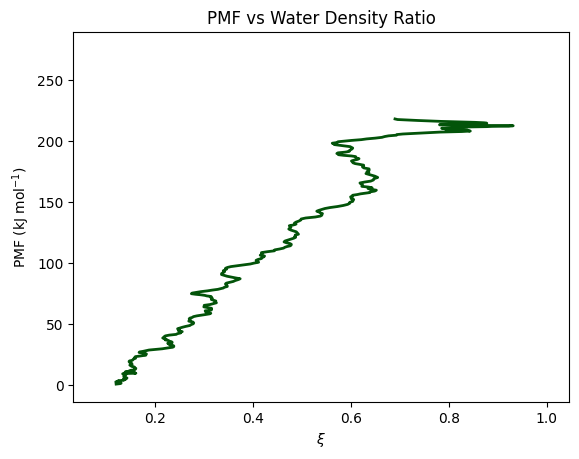

In [132]:
fig,ax = plt.subplots()
df = pd.read_csv(f'{data_folder}1.PMF/1.2_watDensity.csv',index_col=0).rolling(5).mean()
plt.plot(df['Ratio'],df['Energy'],color=pept_colors[pept_num],linewidth=2,label=peptide_names[pept_num])
plt.xlabel(r'$\xi$')
plt.ylabel('PMF (kJ mol$^{-1}$)')
ax.set_ylim(-13.7916025, 289.6236525)
ax.set_xlim(0.03213820078226853, 1.0460886571056063)
plt.title('PMF vs Water Density Ratio')

In [111]:
def plot_water_density(pept_num,memb_num):
    # for pept_num in groups[group_num]:
    fig,ax = plt.subplots()
    df = pd.read_csv(f'{data_folder}1.PMF/{pept_num}.{memb_num}_watDensity.csv',index_col=0)
    plt.plot(df['Ratio'],df['Energy'],color=pept_colors[pept_num],linewidth=2,label=peptide_names[pept_num])
    plt.xlabel(r'$\xi$')
    plt.ylabel('PMF (kJ mol$^{-1}$)')
    ax.set_ylim(-13.7916025, 289.6236525)
    ax.set_xlim(0.03213820078226853, 1.0460886571056063)
    plt.title('PMF vs Water Density Ratio')
    # plt.legend()
    plt.savefig(f'{plots_folder}1.PMF/{pept_num}.{memb_num}_watDensity.svg')
    plt.close()
    # return ax

In [112]:
# plot_water_density(7,2)

In [72]:
# def complete_waterDensity(pept_num,memb_num):
#     df_pmf = pd.read_csv(f'{data_folder}1.PMF/{pept_num}.{memb_num}_pmf.csv',index_col=0)
#     pmf_values = []
#     for dist in [i/10 for i in range(400,1,-1)] + [0.002]:
#         pmf_values.append(df_pmf.loc[df_pmf['Distance'] == dist, 'Energy'].values[0])

#     df = pd.read_csv(f'{data_folder}1.PMF/{pept_num}.{memb_num}_newWatCount.csv',index_col=0)
#     df['Energy'] = pmf_values # in kcal/mol
#     water_mass = c.select_atoms('resname WAT').residues[0].atoms.masses.sum()
#     upper_leaflet = c.select_atoms('resname PC and name P31').atoms[:150].center_of_mass()[2]
#     lower_leaflet = c.select_atoms('resname PC and name P31').atoms[150:].center_of_mass()[2]
#     xdim = list(c.dimensions)[0]
#     wat_volume = xdim*xdim*(upper_leaflet-lower_leaflet)
#     df['Mass'] = df['WatNum']*water_mass
#     df['Density'] = df['Mass']/wat_volume
#     df['EnergyDiff'] = df['Energy'].diff()
#     df['Ratio'] = df['Density']/max(df['Density'])
#     df.to_csv(f'{data_folder}1.PMF/{pept_num}.{memb_num}_newWatDensity.csv')

In [90]:
# complete_waterDensity(3,1)

In [35]:
# def get_water_count(a,pept_num,memb_num,threshold=7.0):
#     df = pd.DataFrame()
#     df['Distance'] = [i for i in range(40,-1,-5)]
#     wcount_total = []
#     for ts in a.trajectory:
#         if ts.frame%50 == 0 or ts.frame == 399: # Only every 50 frames, that is, at the start of each asmd step. Plus at the last frame
#             # print(ts.frame)
#             wcount = 0 # Restart at every ts
#             for resid in a.select_atoms('protein').residues.resids: # For all residues of peptide
#                 for waterid in a.select_atoms('resname WAT').residues.resids: # For all water molecules
#                     atom1 = a.select_atoms(f'protein and resid {resid} and name CA')
#                     atom2 = a.select_atoms(f'resname WAT and resid {waterid} and name O')
#                     dist = mda.analysis.distances.distance_array(atom1,atom2) # Calc distance
#                     if dist < threshold: wcount += 1 # If lower than threshold, sum 1
#             # print(wcount)
#             wcount_total.append(wcount) # Append for this ts
#     df['Wcount'] = wcount_total
#     df.to_csv(f'{data_folder}1.PMF/{pept_num}.{memb_num}_watCount.csv') # Save to df

In [7]:
# wcount_total = []

# for ts in a.trajectory:
#     if ts.frame%50 == 0 or ts.frame == 399:
#         print(ts.frame)
#         w_count = 0
#         p_com = a.select_atoms('protein').center_of_mass()[2]
#         for resid in a.select_atoms('resname WAT').residues.resids:
#             w_com = a.select_atoms(f'resname WAT and resid {resid}').center_of_mass()[2]
#             if p_com + 1 >= w_com and p_com - 1 <= w_com:
#                 w_count +=1
#         print(w_count)
#     wcount_total.append(w_count)


In [83]:
# from scipy.spatial import ConvexHull
# def calculate_water_density(u,pept_num,memb_num,zone=3.5):
#     all_volumes = []
#     all_masses = []
#     # Iterate over all trajectory every 50 frames (and the last)
#     for ts in c.trajectory[:400]:
#         if ts.frame%50 == 0 or ts.frame == 399:
#             # First, select the waters around the protein
#             around = c.select_atoms(f'around {zone} protein')
#             water_around = len(around.select_atoms('resname WAT').residues)
#             # Then, calculate the mass of these atoms
#             water_mass = c.select_atoms('resname WAT').residues[0].atoms.masses.sum() # Mass of 1 water residue
#             total_mass = water_mass*water_around
#             # Now, calculate the volume of these waters
#             coordinates = around.positions
#             hull = ConvexHull(coordinates)
#             volume = hull.volume

#             all_masses.append(total_mass)
#             all_volumes.append(volume)
#     # Unicode characters for Å and ³
#     angstrom_symbol = '\u00C5'
#     cubed_symbol = '\u00B3'
#     df = pd.DataFrame()
#     df['Distance'] = [i for i in range(40,-1,-5)]
#     df['Mass'] = all_masses # Units: u
#     df[f'Volume'] = all_volumes # Units ({angstrom_symbol}{cubed_symbol}) Angstroms^3
#     df[f'Density'] = df['Mass']/df[f'Volume']
#     df.to_csv(f'{data_folder}1.PMF/{pept_num}.{memb_num}_watDensity.csv')

In [36]:
# calculate_water_density(c,1,1)

In [159]:
# def new_water_count(c,pept_num,memb_num,threshold=16):
#     # threshold = 16
#     upper_leaflet = c.select_atoms('resname PC and name P31').atoms[:150].center_of_mass()[2]
#     lower_leaflet = c.select_atoms('resname PC and name P31').atoms[150:].center_of_mass()[2]
#     wat_count = []
#     for ts in c.trajectory[:400]:
#         # if ts.frame%50 == 0 or ts.frame == 399:
#             count = 0
#             for resid in c.select_atoms('resname WAT').residues.resids: # Iterate through all water molecules
#                 com = c.select_atoms(f'resname WAT and resid {resid}').center_of_mass()[2]
#                 if com > (lower_leaflet+threshold) and com < (upper_leaflet-threshold):
#                     count+=1
#             wat_count.append(count)

#     df = pd.DataFrame()
#     df['WatNum'] = wat_count
#     df.to_csv(f'{data_folder}1.PMF/{pept_num}.{memb_num}_newWatCount.csv')

### Hysteresis

In [4]:
hfolder = f'8.Hysteresis/'

In [11]:
def calculate_hysteresis_pmf(memb_num):
    distance = []
    energy = []
    with open(f'8.Hysteresis/{memb_num}.{membranes[memb_num]}/amber/7.2_normal_asmd/_asmd.PMF.dat') as f:
        for line in f:
            parts = line.split()
            distance.append(float(parts[0]))
            energy.append(float(parts[1]))

    df = pd.DataFrame()
    df['Distance'] = distance
    df['Energy'] = energy

    energyR = []
    with open(f'8.Hysteresis/{memb_num}.{membranes[memb_num]}/amber/7.2_return_asmd/_asmd.PMF.dat') as f:
        for line in f:
            parts = line.split()
            distance.append(float(parts[0]))
            energyR.append(float(parts[1]))
    df['EnergyR'] = energyR
    df.to_csv(f'{data_folder}7.Revision/8.{memb_num}_hPMF.csv')

Text(0.5, 1.0, 'Energy of translocation of Arg1 through DPPC:DOPC:DPPS:DOPS:CHOL membrane')

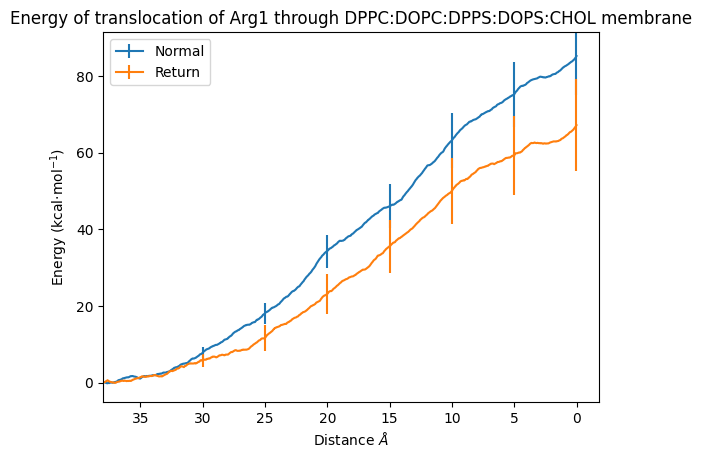

In [19]:
df = pd.read_csv(f'{data_folder}7.Revision/8.{memb_num}_hPMF.csv',index_col=0)
fig,ax = plt.subplots()
# plt.plot(df['Distance'],df['Energy'],label='Normal')
# plt.plot(df['Distance'],df['EnergyR'],label='Return')
plt.errorbar(df['Distance'],df['Energy'],error_normal,label='Normal',errorevery=2499)
plt.errorbar(df['Distance'],df['EnergyR'],error_return,label='Return',errorevery=2499)
plt.legend()
plt.xlabel('Distance $\AA$')
plt.xlim(37.998245,-1.8073449999999998)
plt.ylim(-4.988111,91.4176255)
plt.ylabel('Energy (kcal·mol$^{-1}$)')
plt.title(f'Energy of translocation of Arg1 through {membrane_names[memb_num]} membrane')

In [20]:
def plot_hysteresis_pmf(memb_num):
    df = pd.read_csv(f'{data_folder}7.Revision/8.{memb_num}_hPMF.csv',index_col=0)
    error_normal = np.linspace(0,10,17500)
    error_return = np.linspace(0,12,17500)
    fig,ax = plt.subplots()
    # plt.plot(df['Distance'],df['Energy'],label='Normal')
    # plt.plot(df['Distance'],df['EnergyR'],label='Return')
    plt.errorbar(df['Distance'],df['Energy'],error_normal,label='Normal',errorevery=2499)
    plt.errorbar(df['Distance'],df['EnergyR'],error_return,label='Return',errorevery=2499)
    plt.legend()
    plt.xlabel('Distance $\AA$')
    plt.xlim(37.998245,-1.8073449999999998)
    plt.ylim(-4.988111,91.4176255)
    plt.ylabel('Energy (kcal·mol$^{-1}$)')
    plt.title(f'Energy of translocation of Arg1 through {membrane_names[memb_num]} membrane')
    plt.savefig(f'{plots_folder}7.Revision/8.{memb_num}_hPMF.svg')
    plt.close()
    # return ax

In [23]:
# calculate_hysteresis_pmf(2)
plot_hysteresis_pmf(3)

In [99]:
def calculate_pmf_10aperns(memb_num):
    distance10 = []
    energy10 = []
    with open(f'{hfolder}7.2_10aperns/best_replicas/_asmd.PMF.dat') as f:
        for line in f:
            parts = line.split()
            distance10.append(float(parts[0]))
            energy10.append(float(parts[1]))
    df10 = pd.DataFrame()
    df10['Distance'] = distance10
    df10['Energy'] = energy10
    df10.to_csv(f'{data_folder}7.Revision/8.{memb_num}_PMF10.csv')

In [36]:
def plot_pmf_10aperns(memb_num):
    df = pd.read_csv(f'{data_folder}7.Revision/8.{memb_num}_hPMF.csv',index_col=0)
    df10 = pd.read_csv(f'{data_folder}7.Revision/8.{memb_num}_PMF10.csv',index_col=0)
    fig,ax = plt.subplots()
    # plt.plot(df['Distance'],df['Energy'],label='1 $\AA$·ns$^{-1}$')
    # plt.plot(df10['Distance'],df10['Energy'],label='10 $\AA$·ns$^{-1}$')
    error_normal = np.linspace(0,5,17500)
    error_return = np.linspace(0,6.5,1750)
    plt.errorbar(df['Distance'],df['Energy'],error_normal,errorevery=2499,label='1 $\AA$·ns$^{-1}$')
    plt.errorbar(df10['Distance'],df10['Energy'],error_return,errorevery=249,label='10 $\AA$·ns$^{-1}$')
    plt.errorbar
    plt.legend()
    plt.legend()
    plt.xlabel('Distance $\AA$')
    plt.xlim(37.998245,-1.8073449999999998)
    plt.ylabel('Energy (kcal·mol$^{-1}$)')
    plt.title(f'Energy of translocation of Arg1 through {membrane_names[memb_num]} membrane')
    plt.savefig(f'{plots_folder}7.Revision/8.{memb_num}_PMF10.svg')
    plt.close()

In [37]:
# calculate_pmf_10aperns(1)
plot_pmf_10aperns(1)

### HeatMap

In [300]:
# This is used to prepare a df with the values of the last step (highest value) in the PMF calculation for all the peptides and all the membranes

# df_pmf = pd.DataFrame(columns=['DPPC','DPPC:DOPC:CHOL','DPPC:DOPC:DPPS:DOPSCHOL'],index=['Arg9', 'MAP', 'TP2', 'DynA WT', 'DynA L5S', 'DynA R6W', 'DynA R9C'])
# for pept_num in range(1,8):
#     df = pd.read_csv(f'{data_folder}1.PMF/{pept_num}.1_pmf.csv',index_col=0)
#     df_pmf['DPPC'].iloc[pept_num-1] = df.loc[19999,'Energy']
# df_pmf.to_csv(f'{data_folder}6.Paper/pmf_heatmap.csv')

In [295]:
# data = np.random.randint(100, 301, size=(7, 3))  # Generating random integers between 0 and 300
# df = pd.DataFrame(data,columns=['DPPC', 'DOPC', 'DPPS'],  index=['Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6', 'Column7'])

# corr_matrix = df

In [37]:
# df = pd.read_csv(f'{data_folder}6.Paper/pmf_heatmap.csv',index_col=0)
# df.sem()

In [38]:
def plot_pmf():
    corr_matrix = pd.read_csv(f'{data_folder}6.Paper/pmf_heatmap.csv',index_col=0)
    cmap ='Reds'
    # create a white grid with the same dimensions as the correlation matrix
    fig, ax = plt.subplots(figsize=(12,10))
    ax.set_facecolor('white')
    ax.imshow(np.ones_like(corr_matrix.T), cmap='gray_r', interpolation='nearest')

    # set the tick labels and rotation for the x and y axes
    ax.set_xticks(np.arange(len(corr_matrix.index)))
    ax.set_yticks(np.arange(len(corr_matrix.columns)))

    # shift ticks of x axis to top of the graph
    ax.tick_params(axis='x', which='both', labelbottom=False, labeltop=True, bottom=False, top=True, length=0)

    # format ticks
    ax.set_yticklabels(corr_matrix.columns, fontsize=15, color = "k", fontweight = "bold")
    ax.set_xticklabels(corr_matrix.index, fontsize=15, color = "k", fontweight = "bold")

    # create grid lines between the tick labels
    ax.set_xticks(np.arange(len(corr_matrix.index) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(corr_matrix.columns) + 1) - .5, minor=True)
    ax.grid(which="minor", color="lightgray", linestyle="solid", linewidth=2, )

    # add rectangle around the grid
    rect = plt.Rectangle((-.5, -.5), len(corr_matrix.index), len(corr_matrix.columns), linewidth=5, edgecolor='lightgray', facecolor='none')
    ax.add_patch(rect)

    # create circles with radius proportional to the absolute value of correlation
    for i in range(len(corr_matrix.index)):
        for j in range(len(corr_matrix.columns)):
            correlation = corr_matrix.iat[i, j]
            norm = plt.Normalize(100, 300)  # specify the range of values for the colormap
            sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
            color = sm.to_rgba(correlation)
            circle = Circle((i, j), radius=abs(correlation)/750, facecolor=color,edgecolor='k')
            ax.add_patch(circle)

    # add color bar
    norm = mcolors.Normalize(vmin=100, vmax=300)
    c_scale = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = plt.colorbar(c_scale, ax=ax, orientation='horizontal')
    cbar.set_label('Energy (kcal · $mol^{-1}$ )',fontsize=12)

    plt.xticks(rotation = 45)
    # plt.xlabel('Peptides')
    # plt.ylabel('Membranes')
    plt.title("Peptides' PMF in each membrane composition",fontsize=20,fontweight='bold')
    for i in range(7):
        plt.gca().get_xticklabels()[i].set_color(pept_colors[i+1])
    plt.savefig(f'{plots_folder}6.Paper/PMF_heatmap.svg',transparent=True)
    plt.close()

In [39]:
plot_pmf()

## Electron Density

In [ ]:
# The command to be used in cpptraj is (done in first part):
# density electron ":PC,PS" ":PA" ":WAT" ":Na+" ":Cl-" ":OL" out density.dat

In [40]:
def plot_density(pept_num=pept_num,memb_num=memb_num,stride=25):
    folder = f'{folders[pept_num]}/{memb_num}.{membranes[memb_num]}/'
    electron_groups = ['Polar head','Lipid tail','Water','Sodium ion','Chlorine ion','Cholesterol']
    df = pd.read_csv(f'{folder}density.dat',delimiter="\s+").rolling(stride).mean()
    df['#Z'] = df['#Z']-df.iloc[-1,0]/2
    df.to_csv(f'{data_folder}2.ElectronDensity/{pept_num}.{memb_num}.csv')
    fig,ax = plt.subplots()
    if memb_num == 1:
        for i in range(1,10,2):
            plt.plot(df['#Z'],df.iloc[:,i],label=electron_groups[i//2])
    else:
        for i in range(1,12,2):
            plt.plot(df['#Z'],df.iloc[:,i],label=electron_groups[i//2])
    plt.ylim((-0.0165446, 0.3474366))
    plt.xlabel('Box ($\AA$)')
    plt.ylabel('Electron density (e · $\AA^{-3}$ )')
    plt.legend(bbox_to_anchor=(1,1))
    plt.savefig(f'{plots_folder}2.ElectronDensity/{pept_num}.{memb_num}.svg',transparent=True)
    plt.close()


In [41]:
plot_density(0,memb_num)

## Pore

In [24]:
def analyse_pore(u=u,pept_num=pept_num,memb_num=memb_num):
    #Getting only min radii of each frame w/ Numpy arrays
    Wpos = []
    for ts in u.trajectory:
        waters = u.select_atoms("resname WAT and name O")
        Wpos.append(waters.positions)

    Wpos = np.array(Wpos)

    #NUMPY ARRAYS --> x12 time faster
    pore_per_ts = [] #Here we will save, for each ts, the limiting point of the porus (min radii accross all Z stacks)

    #Iterate over trajectory positions X and Y of waters
    for ts in Wpos:
        pore_radiis = set() #Save all Z-stack por radii for each ts
        for i in range(10,80, 2): #Iterate over Z positions 10 and 80 A (modificable) every 2 A
            slice_w = ts[(ts[...,2] > i) & (ts[...,2] < i+2)] #Slicing array by Z coordinate
            X = slice_w[:,0] # X positions
            Y = slice_w[:,1] # Y positions
            
            if len(X) == 0 or len(Y) == 0:
                WXOM = [0,0]
                pore_radiis.add(0)
            else:
                WCOM = [sum(X)/len(X), sum(Y)/len(Y)] #Center of mass of the waters
            
                #Distance between the WCOM and the furthest water from it
                #This is the radii of the circle that contains ALL waters for that stack
                pore_radiis.add(max([distance.euclidean(WCOM, [X[i],Y[i]]) for i,x in enumerate(X)]))
        #For each ts, add the radii of the smallest circle
        
        #This will be the Z stack with the smaller circle --> water pore bottleneck
        pore_per_ts.append(min(pore_radiis))
        
    df = pd.DataFrame()
    df['Time'] = [i/10 for i in range(1000)]
    df['Pore'] = pore_per_ts
    df.to_csv(f'{data_folder}3.Pore/{pept_num}.{memb_num}.csv')

In [25]:
def plot_pore(group_num,memb_num):
    fig, ax = plt.subplots()
    for pept_num in all_groups[group_num]:
        df = pd.read_csv(f'{data_folder}3.Pore/{pept_num}.{memb_num}.csv',index_col=0).rolling(25).mean()
        plt.plot(df['Time'],df['Pore'],color=pept_colors[pept_num],linewidth=2,label=peptide_names[pept_num])
    plt.xlabel('Time (ns)')
    plt.ylabel('Radius ($\AA$)')
    plt.legend(bbox_to_anchor=(1,1))
    ax.set_ylim(-1.162315238239082, 24.408620003020722)
    plt.title(f'Pore radius distribution in {membrane_names[memb_num]}')
    plt.savefig(f'{plots_folder}3.Pore/{memb_num}_{group_names[group_num].lower()}_pore.svg',transparent=True)
    plt.close()
    # return ax

In [42]:
analyse_pore(u,pept_num,memb_num)
plot_pore(0,memb_num)


## Occupancy

In [4]:
def analyse_occupancy(u,traj_file,parm_file,folder,pept_num,memb_num,lipid='PC'):
    # Save resnames in a list and convert to 1 letter code
    resnames_long = list(u.select_atoms('protein').residues.resnames)
    resnames_short = [mda.lib.util.convert_aa_code(i) for i in resnames_long]
    
    # Initialize lipid interaction: collect the lipids (numbers from 0 to 299) that are interacting with each residue in each frame
    cutoffs = [0.35]
    nprot = 1
    timeunit = 'ns'
    li = LipidInteraction(traj_file, topfile_list=parm_file, cutoffs=cutoffs, lipid=lipid,
                        nprot=nprot, save_dir=folder)
    li.collect_residue_contacts()

    # Create array of residue length and simulation duration
    upper_contacts = [[[[] for j in range(len(u.trajectory))]] for i in range(peptides_length[pept_num])]
    lower_contacts = [[[[] for j in range(len(u.trajectory))]] for i in range(peptides_length[pept_num])]

    # Add the lipid numbers of interaction in the upper_ or lower_contacts arrays in the correct residue and frame
    for residue in range(peptides_length[pept_num]):
        for frame,contacts in enumerate(li._contact_residues_high[residue][0]):
            for lipid_number in contacts:
                if lipid_number > 149: #Lipid numbers 0 to 149 are upper leaflet, 150 to 299 lower leaflet
                    lower_contacts[residue][0][frame].append(lipid_number)
                elif lipid_number <= 149:
                    upper_contacts[residue][0][frame].append(lipid_number)
    
    # Compute occupancies
    upper_occupancies = []
    for residue in range(peptides_length[pept_num]):
        residue_i_contacts = []
        for i in range(len(u.trajectory)):
            if len(upper_contacts[residue][0][i]) > 0: # If there is at least one lipid interacting, we add 1 (since we want to see whether there is interaction or not)
                residue_i_contacts.append(1)
            else: residue_i_contacts.append(0) # If no lipid interacting, we add 0
        upper_occupancies.append(sum(residue_i_contacts)/len(u.trajectory)*100) # Sum and divide by trajectory length and multiply by 100 to get the percentage of occupancy per residue

    lower_occupancies = []
    for residue in range(peptides_length[pept_num]):
        residue_i_contacts = []
        for i in range(len(u.trajectory)):
            if len(lower_contacts[residue][0][i]) > 0:
                residue_i_contacts.append(1)
            else: residue_i_contacts.append(0)
        lower_occupancies.append(sum(residue_i_contacts)/len(u.trajectory)*100)
    
    df_upper = pd.DataFrame()
    df_upper['Resnames'] = resnames_short
    df_upper['Occupancies'] = upper_occupancies
    df_upper.to_csv(f'{data_folder}4.Occupancy/{pept_num}.{memb_num}_upper_{lipid}.csv')

    df_lower = pd.DataFrame()
    df_lower['Resnames'] = resnames_short
    df_lower['Occupancies'] = lower_occupancies
    df_lower.to_csv(f'{data_folder}4.Occupancy/{pept_num}.{memb_num}_lower_{lipid}.csv')
    # return df_upper,df_lower

In [41]:
df['Resnames'].loc[0]

'R'

In [ ]:
for i in range(1,len(df['Resnames'])):
    []

In [46]:
df = pd.read_csv(f'{data_folder}4.Occupancy/{pept_num}.{memb_num}_upper_PC.csv',index_col=0)
categories=[f'{df["Resnames"].loc[i-1]}{str(i)}' for i in range(1,len(df['Resnames'])+1)]
categories

['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9']

In [68]:
def plot_occupancy(pept_num,memb_num,part='upper',lipid='PC'):
    peptide_name = peptide_names[pept_num]
    peptide_color = pept_colors[pept_num]
    df = pd.read_csv(f'{data_folder}4.Occupancy/{pept_num}.{memb_num}_{part}_{lipid}.csv',index_col=0)
    # ------- PART 1: Create background
 
    # number of variable
    # categories=list(df['Resnames'])
    categories = [f'{df["Resnames"].loc[i-1]}{str(i)}' for i in range(1,len(df['Resnames'])+1)] # Doing a mix of resname and resid (R1,R2...)
    N = len(categories)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * 3.14 for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    # If you want the first axis to be on top:
    ax.set_theta_offset(3.14 / 2)
    ax.set_theta_direction(-1)
    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories, size=15, color=peptide_color, weight='bold')
    plt.tick_params(axis="x", which="major", pad=25)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([20,40,60,80,100], ["20%","40%","60%","80%","100%"], color="grey", size=25)
    plt.ylim(0,100)
    

    # ------- PART 2: Add plots

    # Plot each individual = each line of the data
    # I don't make a loop, because plotting more than 3 groups makes the chart unreadable

    # Ind1
    values=df['Occupancies'].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=3, linestyle='solid', label=f'{peptide_name}', color=peptide_color)
    ax.fill(angles, values, alpha=0.2, color=peptide_color)
    plt.xticks(angles[:-1], categories, size=35, color=peptide_color, weight='bold')
    plt.tick_params(axis="x", which="major", pad=40)

    # Add legend
#     plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.rcParams["figure.figsize"] = (10,10)

    # Show the graph
    plt.savefig(f'{plots_folder}4.Occupancy/{pept_num}.{memb_num}_{part}_{lipid}.svg', bbox_inches='tight')
    plt.close()

In [64]:
plot_occupancy(1,1)

## Lipid Parameters

In [27]:
def analyse_membrane_thickness(u,pept_num,memb_num):
    leaflets = AssignLeaflets(universe=u, lipid_sel="resname PC PS")
    leaflets.run(start=None, stop=None, step=None)  # this will use every frame in the trajectory
    memb_thickness = MembThickness(universe=u, leaflets=leaflets.filter_leaflets("resname PC PS"), lipid_sel="resname PC PS") # Get only polar heads
    memb_thickness.run(start=None, stop=None, step=None)
    
    # Select which frames to use and perform the analysis
    df = pd.DataFrame()
    df['Time'] = [i/10 for i in range(1000)]
    df['MT'] = memb_thickness.memb_thickness
    df.to_csv(f'{data_folder}5.LipidParameters/{pept_num}.{memb_num}_mt.csv')
    return leaflets

def plot_membrane_thickness(group_num,memb_num):
    fig,ax = plt.subplots()
    for pept_num in all_groups[group_num]:
        df = pd.read_csv(f'{data_folder}5.LipidParameters/{pept_num}.{memb_num}_mt.csv',index_col=0).rolling(100).mean()
        plt.plot(df['Time'],df['MT'],color=pept_colors[pept_num],linewidth=2,label=peptide_names[pept_num])
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel('Time (ns)')
    plt.ylabel('Thickness ($\AA$)')
    plt.title(f'{group_names[group_num]} Membrane thickness in {membrane_names[memb_num]} membranes')
    ax.set_ylim(35.12850380172932,43.04469496596846)
    plt.savefig(f'{plots_folder}5.LipidParameters/{memb_num}_{group_names[group_num].lower()}_mt.svg',transparent=True)
    plt.show()
    # return ax


In [43]:
leaflets = analyse_membrane_thickness(u,0,3)

In [12]:
def analyse_area_per_lipid(u,leaflets,pept_num,memb_num):
    areas = AreaPerLipid(universe=u, lipid_sel="resname PC PS", leaflets=leaflets.leaflets)
    areas.run(start=None, stop=None, step=None)

    apl = []
    for i in range(len(u.trajectory)):
        apl.append(np.mean(areas.areas.T[i]))

    df = pd.DataFrame()
    df['Time'] = [i/10 for i in range(1000)]
    df['APL'] = apl
    df.to_csv(f'{data_folder}5.LipidParameters/{pept_num}.{memb_num}_apl.csv')

def plot_area_per_lipid(group_num,memb_num):
    fig,ax = plt.subplots()
    for pept_num in all_groups[group_num]:
        df = pd.read_csv(f'{data_folder}5.LipidParameters/{pept_num}.{memb_num}_apl.csv',index_col=0).rolling(100).mean()
        plt.plot(df['Time'],df['APL'],color=pept_colors[pept_num],linewidth=2,label=peptide_names[pept_num])
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel('Time (ns)')
    plt.ylabel('Area per lipid ($\AA {^2}$)')
    plt.title(f'{group_names[group_num]} Area per Lipid in {membrane_names[memb_num]} membranes')
    ax.set_ylim(55.10858687713933, 79.57832261499635)
    plt.savefig(f'{plots_folder}5.LipidParameters/{memb_num}_{group_names[group_num].lower()}_apl.svg',transparent=True)
    plt.show()
    # return ax

In [44]:
analyse_area_per_lipid(u,leaflets,0,3)

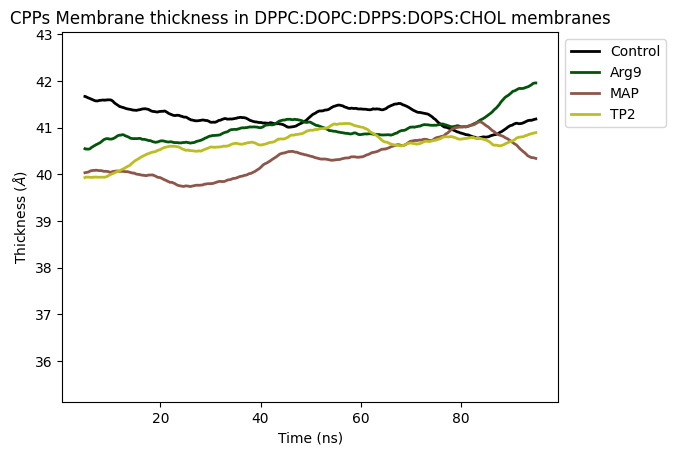

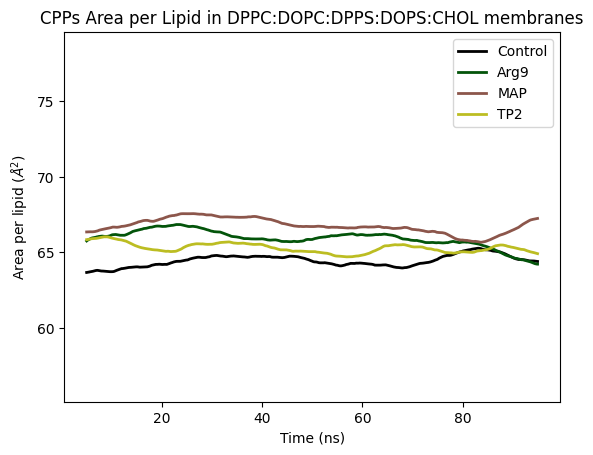

In [45]:
plot_membrane_thickness(0,3)
plot_area_per_lipid(0,3)

In [ ]:
def analyse_lipid_order_parameters(u, pept_num, memb_num,lipid='PA'):
    # Create an empty DataFrame to store lipid order parameters
    df_lop = pd.DataFrame()
    lop = []  # List to store order parameters
    
    # Iterate over carbon numbers 2 to 16
    for c_number in range(2, 17):
        # Define selection criteria for atoms
        selection = f'resname {lipid} and name C1{c_number} H{c_number}R H{c_number}S'
        # Select atoms based on the selection criteria
        atom_selection = u.select_atoms(selection)
        # Extract trajectory data (positions) of selected atoms
        skip = len(set(atom_selection.names))
        data = u.trajectory.timeseries(atom_selection)
        # Transpose the trajectory data so that its structure is (atoms,frames,positions)
        data2 = np.transpose(data, (1, 0, 2))
        # Calculate displacement vectors between frames
        conc_data = [data2[n::skip]-data2[0::skip] for n in range(1,skip)]
        cd = np.concatenate(conc_data, axis=0) #Then concatenate
        #     cd = np.concatenate((data2[1::3] - data2[0::3], data2[2::3] - data2[0::3]), axis=0)
        # Calculate magnitude of displacement vectors
        cd_r = np.sqrt(np.sum(np.power(cd, 2), axis=-1))
        # Calculate cosine of the angle between displacement vectors and z-axis
        cos_theta = cd[..., 2] / cd_r
        # Calculate lipid order parameter using the formula
        s_cd = -0.5 * (3. * np.square(cos_theta) - 1)
        # Reshape the array to appropriate dimensions
        # s_cd.shape = (int(s_cd.shape[0]/(skip-1)), s_cd.shape[1], -1)
        # Calculate average order parameter
        order_param = np.average(s_cd)
        # order_param = np.std(s_cd) # To calculate std
        # Append the order parameter to the list
        lop.append(order_param)
    
    # Create a list of carbon numbers
    c_numbers = [i for i in range(2, 17)]
    # Add carbon numbers and order parameters to the DataFrame
    df_lop['Cn'] = c_numbers
    df_lop['LOP'] = lop
    # Save DataFrame to a CSV file
    df_lop.to_csv(f'{data_folder}5.LipidParameters/{pept_num}.{memb_num}_lop_{lipid.lower()}.csv')
    # df_lop.to_csv(f'{data_folder}5.LipidParameters/{pept_num}.{memb_num}_lop_{lipid.lower()}_std.csv')


In [ ]:
def plot_lipid_order_parameters(group_num,memb_num,lipid='PA'):
    fig,ax = plt.subplots()
    for pept_num in all_groups[group_num]:
        df_lop = pd.read_csv(f'{data_folder}5.LipidParameters/{pept_num}.{memb_num}_lop_{lipid.lower()}.csv')
        plt.plot(df_lop['Cn'],df_lop['LOP'],color=pept_colors[pept_num],label=peptide_names[pept_num])
        plt.scatter(df_lop['Cn'],df_lop['LOP'],color=pept_colors[pept_num],facecolors='None') # Add also points to the graph (empty, only circunferences)
    plt.xlabel('Carbon number')
    plt.ylabel('SCD')
    plt.title(f'{group_names[group_num]} LOP in {membrane_names[memb_num]}')
    ax.set_ylim(0.0034584139999999965, 0.384957466)
    plt.savefig(f'{plots_folder}5.LipidParameters/{memb_num}_{group_names[group_num].lower()}_lop_{lipid.lower()}.svg',transparent=True)
    plt.close()
    # return ax

In [46]:
analyse_lipid_order_parameters(u,0,3)

In [47]:
plot_lipid_order_parameters(0,3)

## ALL

In [108]:
def analyse_everything(start_pept=1,last_pept=2,start_memb=1,last_memb=2):
    for memb_num in range(start_memb,last_memb):
        for pept_num in range(start_pept,last_pept):
                peptide = peptides[pept_num]
                peptide_name = peptide_names[pept_num]
                membrane = membranes[memb_num]
                membrane_name = membrane_names[memb_num]
                pept_color = pept_colors[pept_num]
                folder = f'{folders[pept_num]}/{memb_num}.{membrane}/'
                parm_file = f'{folder}step5_input.parm7'
                traj_file = f'{folder}step7.3_final_relaxation_100ns.nc'
                center_relax = f'{folder}step7.4_asmd_relax_centered.nc'

                # u = mda.Universe(parm_file,traj_file)
                # c = mda.Universe(parm_file,center_relax)
                # if memb_num == 1: pc_num = 150
                # elif memb_num == 2: pc_num = 100
                # else: pc_num == 120
                # upper_leaflet_z = c.select_atoms('resname PC PS and name O31').atoms[:pc_num].center_of_mass()[2]
                # lower_leaflet_z = c.select_atoms('resname PC PS and name O31').atoms[pc_num:].center_of_mass()[2]
                # print(upper_leaflet_z,lower_leaflet_z,upper_leaflet_z-lower_leaflet_z)
                # center_traj(folder=folder)
                # calculate_pmf(pept_num=pept_num,memb_num=memb_num)
                # analyse_pmf(folder=folder,pept_num=pept_num,memb_num=memb_num)
                # new_water_density(c,pept_num,memb_num)
                plot_water_density(pept_num,memb_num)
                # plot_pmf(pept_num=pept_num,memb_num=memb_num,peptide_name=peptide_name,membrane_name=membrane_name)
                # plot_density(folder=folder,pept_num=pept_num,memb_num=memb_num,stride=25)
                # analyse_pore(u=c,pept_num=pept_num,memb_num=memb_num)
                # analyse_occupancy(u=u,traj_file=traj_file,parm_file=parm_file,folder=folder,pept_num=pept_num,memb_num=memb_num,lipid='PC')
                # plot_occupancy(part='upper',pept_num=pept_num,memb_num=memb_num)
                # plot_occupancy(part='lower',pept_num=pept_num,memb_num=memb_num)
                # if memb_num == 3:
                    # analyse_occupancy(u=u,traj_file=traj_file,parm_file=parm_file,folder=folder,pept_num=pept_num,memb_num=memb_num,lipid='PS')
                    # plot_occupancy(part='upper',pept_num=pept_num,memb_num=memb_num,lipid='PS')
                    # plot_occupancy(part='lower',pept_num=pept_num,memb_num=memb_num,lipid='PS')
                # leaflets = analyse_membrane_thickness(u=u,pept_num=pept_num,memb_num=memb_num)
                # analyse_area_per_lipid(u=u,leaflets=leaflets,pept_num=pept_num,memb_num=memb_num)
                # if memb_num == 2 or memb_num == 3:
                    # analyse_lipid_order_parameters(u,pept_num,memb_num,lipid='OL')
                # analyse_lipid_order_parameters(u,pept_num,memb_num,lipid='PA')
                
        # for group_num in [0,1]:
            # plot_all_replica_pmf(group_num=group_num,memb_num=memb_num)
            # plot_pmf_all(data_folder=data_folder,plots_folder=plots_folder,memb_num=memb_num,membrane_name=membrane_name,group_num=group_num)
            # plot_pore(group_num=group_num,memb_num=memb_num)
            # plot_membrane_thickness(memb_num=memb_num,group_num=group_num)
            # plot_area_per_lipid(memb_num=memb_num,group_num=group_num)
            # plot_lipid_order_parameters(group_num,memb_num,'PA')
            # if memb_num > 1: plot_lipid_order_parameters(group_num,memb_num,'OL')

In [ ]:
analyse_everything(1,8,1,4)